# Machine Learning for Medicine
# **Data Integration with Deep Learning**.
# **MLP on the Micr-Obes Datasets**.
> * Student : **Merrouche Aymen**

## **Introduction**
> In this notebook we train a deep learning architecture, precisely a **two layers feed forward neural network**, for a **binary classification** task on the Micr-Obes datasets: environment, host and micr. In each dataset different features are recorded, we will also try to merge these features and compare the results. We will use sklearn. Moreover, we will use grid search to select the optimal hyperparameters. We will also compare the results obtained with this deep learning approach and the results yielded by traditional machine learning algorithms, namely: **SVM**, **Gradient Boosting** and **Random Forests** (also trained with grid search and a 10 folds cross-validation).
> We get the following final results :
<img src=./figs/comparison_mlp_ml_microbes.png>

In [1]:
import pandas as pd
import numpy as np
import keras
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
# utils
import joblib
import matplotlib.pyplot as plt
import time

# coded functions
from models import *
from utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

## Import The Micr-Obes Cohort :
> Three heterogeneous data sets (environment, host, and gut microbiota)

### Classes : 

In [3]:
# SPLEX micro dataset, load and display some information about the data
from sklearn.preprocessing import LabelEncoder
classes = pd.read_table("./data/classes.rtf", sep="\\n", skiprows=9, header=None, names=["class"])
classes = LabelEncoder().fit_transform(classes)

In [26]:
valid_index = np.where(classes != 3)[0].tolist()
classes = classes[valid_index]
print("Number of examples where the class is available : ",len(valid_index))

Number of examples where the class is available :  45


> We observe that the dataset is extremely small.

### Environment : 

In [5]:
# SPLEX env dataset, load and display some information about the data
splex_env = pd.read_table("./data/SPLEX_env.txt", sep=" ")
splex_env = splex_env.iloc[valid_index]
print("Number of examples :", splex_env.shape[0])
print("Dimension of the problem :", splex_env.shape[1])
print("Sample of the data :")
splex_env.head()

Number of examples : 45
Dimension of the problem : 63
Sample of the data :


,cWI_ap,cSI_ap,cLI_ap,Food_intake_alim,Water_alim,Pr_alim,Prpourc_alim,CHO_alim,CHOpourc_alim,Sugar_alim,...,pain_et_produits_panifies,produits_aquatiques,produits_sucres,sauces_et_condiments,Soupes,tubercules,viande_blanche,viande_rouge,viennoiseries_patisseries_biscui,yaourt_fromage_blanc
0,12,8,2,44,33,15,3,43,39,43,...,17,40,18,2,19,39,19,2,43,36
1,1,7,1,18,37,43,22,29,27,42,...,2,28,27,4,4,15,36,4,30,13
2,7,12,14,21,20,25,10,32,33,19,...,5,11,38,19,38,22,30,31,36,14
3,11,2,7,23,43,28,20,31,29,1,...,42,30,42,28,28,15,2,33,10,41
4,11,11,2,3,1,45,30,9,30,16,...,3,21,15,2,5,2,22,2,27,11


#### **Most Discriminative Features :**

In [6]:
# some statistics
std_pd_env = pd.DataFrame(splex_env).describe().T.sort_values(by=['std'], ascending=False)
std_pd_env.head()

,count,mean,std,min,25%,50%,75%,max
CHO_alim,45.0,24.333333,13.970749,1.0,12.0,26.0,37.0,45.0
Food_intake_alim,45.0,24.888889,13.827217,1.0,12.0,26.0,37.0,45.0
yaourt_fromage_blanc,45.0,21.711111,13.818009,1.0,10.0,21.0,33.0,45.0
produits_sucres,45.0,21.133333,13.610825,1.0,9.0,21.0,33.0,44.0
Prpourc_alim,45.0,21.177778,13.606965,1.0,9.0,21.0,33.0,44.0


#### **Variance Across Feature Variances :**

In [7]:
std_pd_env.describe()

,count,mean,std,min,25%,50%,75%,max
count,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,45.0,19.529453,11.238482,1.063492,10.126984,19.984127,28.841270,38.095238
std,0.0,5.794003,3.565240,0.304431,3.034703,5.881880,8.917555,11.597712
min,45.0,1.755556,0.434613,1.000000,2.000000,2.000000,2.000000,2.000000
25%,45.0,18.677778,11.494403,1.000000,9.000000,19.000000,28.500000,39.500000
50%,45.0,21.177778,12.678105,1.000000,10.000000,21.000000,32.000000,43.000000
75%,45.0,23.355556,13.176578,1.000000,12.000000,24.000000,33.000000,44.500000
max,45.0,24.888889,13.970749,3.000000,15.000000,26.000000,37.000000,45.000000


> We observe a high std across feature variances, meaning that there are features that have a high std across examples and others with a across examples.

### Host : 

In [8]:
# SPLEX host dataset, load and display some information about the data
splex_host = pd.read_table("./data/SPLEX_host.txt", sep=" ")
splex_host = splex_host.iloc[valid_index]
print("Number of examples :", splex_host.shape[0])
print("Dimension of the problem :", splex_host.shape[1])
print("Sample of the data :")
splex_host.head()

Number of examples : 45
Dimension of the problem : 45
Sample of the data :


,Sexe,Age,cBMI_corp,cTT_corp,cTH_corp,cWHR,cMGkg_corp,cMGpourc_corp,cMMkg_corp,cMMpourc_corp,...,cIL6_inf,cLPS_inf,cvegf_inf,ceotaxin_inf,cip10_inf,cmcp1_inf,cmip1b_inf,cCD14_infl,cLeptin_meta,cAdipo_meta
0,2,41,-0.93755,5.0,-1.0,0.05389,-2.53,-1.66,-0.31,1.78,...,25,33,28,34,16,23,13,14,47,5
1,1,50,-2.54899,-9.0,-5.0,-0.04326,-2.69,-1.34,-1.99,1.01,...,23,22,13,6,2,3,43,12,21,27
2,1,56,-1.23884,0.0,1.0,-0.00787,0.33,0.73,-1.22,-0.87,...,15,21,48,37,36,48,47,15,9,18
3,1,34,-2.90913,-15.0,-6.0,-0.07791,-2.82,0.33,-3.77,-0.53,...,35,31,6,1,21,49,10,44,33,29
4,1,56,-2.47137,-11.0,-4.0,-0.07015,-3.97,-1.97,-2.47,1.62,...,14,14,27,24,15,13,20,20,17,21


#### **Most Discriminative Features :**

In [9]:
# some statistics
std_pd_host = pd.DataFrame(splex_host).describe().T.sort_values(by=['std'], ascending=False)
std_pd_host.head()

,count,mean,std,min,25%,50%,75%,max
cHOMA_S_meta,45.0,44.404444,39.362020,-9.7,15.9,36.9,61.5,170.3
cHOMA_B_meta,45.0,-17.035556,21.488212,-76.3,-27.2,-12.4,-1.8,22.1
cCD14_infl,45.0,24.400000,14.688276,1.0,12.0,23.0,38.0,49.0
cLPS_inf,45.0,25.755556,14.660019,1.0,13.0,27.0,38.0,49.0
cAdipo_meta,45.0,24.222222,14.483359,1.0,12.0,24.0,36.0,49.0


#### **Variance Across Feature Variances :**

In [10]:
std_pd_host.describe()

,count,mean,std,min,25%,50%,75%,max
count,45.0,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,45.0,8.721736,7.265024,-5.230245,3.286672,8.625481,14.171480,22.708372
std,0.0,14.581680,8.009589,13.993779,9.783237,13.872018,19.469202,31.480770
min,45.0,-17.035556,0.017933,-76.300000,-27.200000,-12.400000,-5.270000,-0.592420
25%,45.0,-0.898000,0.661366,-5.590000,-1.645200,-0.770000,-0.194800,0.710000
50%,45.0,0.023059,3.775853,-1.200000,-0.059520,0.020762,0.180000,4.380000
75%,45.0,24.000000,13.754595,1.000000,12.000000,24.000000,35.000000,48.000000
max,45.0,44.404444,39.362020,24.000000,32.000000,41.000000,61.500000,170.300000


### Micro : 

In [11]:
# SPLEX micro dataset, load and display some information about the data
splex_micro = pd.read_table("./data/SPLEX_micro.txt", sep=" ")
splex_micro = splex_micro.iloc[valid_index] 
print("Number of examples :", splex_host.shape[0])
print("Dimension of the problem :", splex_host.shape[1])
print("Sample of the data :")
splex_micro.head()

Number of examples : 45
Dimension of the problem : 45
Sample of the data :


,cecoli_norm_bact,cbacteroidetes_norm_bact,cbifides_norm_bact,clacto_norm_bact,cfprau_norm_bact,ccleptum_norm_bact,ccoccoides_norm_bact,cAkkqPCR,Gene_count,cX7m_gene_count
0,1.02555,0.27973,-0.11663,0.04785,-0.02938,0.50587,-0.37663,0.61550,2,17
1,-0.59078,0.19565,-0.31912,0.14836,-0.08875,0.43344,-0.17099,-1.03278,1,35
2,-0.05058,-0.13718,-0.36749,-0.45940,0.05092,-0.11966,-0.46899,-0.88442,1,5
3,1.96951,0.39088,0.24297,-0.07781,-0.29256,-0.06845,0.38540,0.75423,2,23
4,1.87576,-0.05225,-1.07598,-0.57003,-0.43109,-0.60245,-0.42526,-1.32914,2,36


#### **Most Discriminative Features :**

In [12]:
# some statistics
std_pd_micro = pd.DataFrame(splex_micro).describe().T.sort_values(by=['std'], ascending=False)
std_pd_micro.head()

,count,mean,std,min,25%,50%,75%,max
cX7m_gene_count,45.0,18.200000,9.416137,1.00000,12.00000,17.00000,25.00000,36.00000
cAkkqPCR,45.0,-0.326402,1.626035,-4.54249,-1.11642,-0.28774,0.59771,3.63869
cecoli_norm_bact,45.0,0.093213,1.141663,-1.84345,-0.59078,0.09699,0.71868,3.34908
cbifides_norm_bact,45.0,-0.180962,0.887316,-2.37582,-0.60559,0.07149,0.32898,1.46649
clacto_norm_bact,45.0,-0.388538,0.787970,-2.57058,-0.75535,-0.39269,-0.02051,2.00574


#### **Variance Across Feature Variances :**

In [13]:
std_pd_micro.describe()

,count,mean,std,min,25%,50%,75%,max
count,10.0,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,45.0,1.924835,1.683764,-1.342204,0.910038,1.761923,2.984526,6.000666
std,0.0,5.740348,2.740097,1.672486,3.937003,5.367346,7.755803,10.585668
min,45.0,-0.388538,0.332078,-4.542490,-1.116420,-0.392690,-0.020510,1.234780
25%,45.0,-0.157437,0.673450,-2.242727,-0.601888,-0.109167,0.342832,2.001435
50%,45.0,0.092782,0.775561,-1.390355,-0.341230,0.084240,0.396230,3.010135
75%,45.0,0.224271,1.078076,-0.529088,-0.050300,0.166882,0.688438,3.626202
max,45.0,18.200000,9.416137,1.000000,12.000000,17.000000,25.000000,36.000000


### Concated Dataset : 

In [14]:
# SPLEX dataset, load and display some information about the data
splex_full = pd.concat([splex_env,splex_host,splex_micro], axis=1)
print("Number of examples :", splex_full.shape[0])
print("Dimension of the problem :", splex_full.shape[1])
print("Sample of the data :")
splex_full.head()

Number of examples : 45
Dimension of the problem : 118
Sample of the data :


,cWI_ap,cSI_ap,cLI_ap,Food_intake_alim,Water_alim,Pr_alim,Prpourc_alim,CHO_alim,CHOpourc_alim,Sugar_alim,...,cecoli_norm_bact,cbacteroidetes_norm_bact,cbifides_norm_bact,clacto_norm_bact,cfprau_norm_bact,ccleptum_norm_bact,ccoccoides_norm_bact,cAkkqPCR,Gene_count,cX7m_gene_count
0,12,8,2,44,33,15,3,43,39,43,...,1.02555,0.27973,-0.11663,0.04785,-0.02938,0.50587,-0.37663,0.61550,2,17
1,1,7,1,18,37,43,22,29,27,42,...,-0.59078,0.19565,-0.31912,0.14836,-0.08875,0.43344,-0.17099,-1.03278,1,35
2,7,12,14,21,20,25,10,32,33,19,...,-0.05058,-0.13718,-0.36749,-0.45940,0.05092,-0.11966,-0.46899,-0.88442,1,5
3,11,2,7,23,43,28,20,31,29,1,...,1.96951,0.39088,0.24297,-0.07781,-0.29256,-0.06845,0.38540,0.75423,2,23
4,11,11,2,3,1,45,30,9,30,16,...,1.87576,-0.05225,-1.07598,-0.57003,-0.43109,-0.60245,-0.42526,-1.32914,2,36


#### **Most Discriminative Features :**

In [15]:
# some statistics
std_pd_full = pd.DataFrame(splex_full).describe().T.sort_values(by=['std'], ascending=False)
std_pd_full.head()

,count,mean,std,min,25%,50%,75%,max
cHOMA_S_meta,45.0,44.404444,39.362020,-9.7,15.9,36.9,61.5,170.3
cHOMA_B_meta,45.0,-17.035556,21.488212,-76.3,-27.2,-12.4,-1.8,22.1
cCD14_infl,45.0,24.400000,14.688276,1.0,12.0,23.0,38.0,49.0
cLPS_inf,45.0,25.755556,14.660019,1.0,13.0,27.0,38.0,49.0
cAdipo_meta,45.0,24.222222,14.483359,1.0,12.0,24.0,36.0,49.0


#### **Variance Across Feature Variances :**

In [16]:
std_pd_full.describe()

,count,mean,std,min,25%,50%,75%,max
count,118.0,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000
mean,45.0,13.915949,8.913458,-1.540535,6.737293,14.108185,21.055609,29.507487
std,0.0,11.828776,6.313689,9.099394,7.465616,11.666115,16.373593,23.607515
min,45.0,-17.035556,0.017933,-76.300000,-27.200000,-12.400000,-5.270000,-0.592420
25%,45.0,0.145612,1.458846,-0.886483,-0.052140,0.128732,0.454723,3.408995
50%,45.0,19.555556,12.189269,1.000000,9.000000,20.000000,29.500000,41.000000
75%,45.0,23.300000,13.184453,1.000000,12.000000,24.000000,33.750000,45.000000
max,45.0,44.404444,39.362020,24.000000,32.000000,41.000000,61.500000,170.300000


> Overall, we can say that the datasets are extremely small on one hand and there are high dimensional on the other one which suggests that the classification task in this setting might be challenging.

In [28]:
medical_data = {"env":(splex_env, classes),"host":(splex_host, classes),"micr":(splex_micro, classes),"full":(splex_full, classes)}

## **The Training and Results :**
> In this section we train all the models: MLP, SVM, Gradient boosting and random forests with a 10 folds cross-validation and perform grid search to select optimal hyperparameters. Due to the small size of the dataset train test split is not performed.

**1 - Let's create our models and define the grids for grid search :**

In [18]:
# declare our MLP
# we set the number of epochs to 100, the dataset is relatively small 
# and the task is not complicated so that should be enough
mlp_breast_sklearn = MLPClassifier(max_iter=100)

In [35]:
# hyperparameters to test

# hidden layers
hidden_layers = []
pow_2 = [ 2**j for j in range(4,10)]
for i in range(len(pow_2)-1):
    hidden_layers.append((pow_2[i], pow_2[i+1]))
# l2 regularization
alpha = [10**-i for i in range(2, 5)]
# learning rate
lr = [10**-i for i in range(2, 5)]
# batch size
batch_size = [ 2**j for j in range(4,8)]


# parameter space
parameter_space_mlp = {
    'hidden_layer_sizes': hidden_layers,
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': alpha,
    'learning_rate': ['constant','adaptive', 'invscaling'],
    'learning_rate_init': lr,
    'batch_size' : [16, 32]
}
print("parameters to test : ", parameter_space_mlp)

parameters to test :  {'hidden_layer_sizes': [(16, 32), (32, 64), (64, 128), (128, 256), (256, 512)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [0.01, 0.001, 0.0001], 'learning_rate': ['constant', 'adaptive', 'invscaling'], 'learning_rate_init': [0.01, 0.001, 0.0001], 'batch_size': [16, 32]}


In [36]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [42]:
# SVM
svm_clf = SVC()
parameter_space_svm = {
    "C" : [0.1, 0.5, 1],
    "kernel" : ["linear", "poly", "rbf", "sigmoid"],
    "gamma" : ["scale", "auto"]
}
# Random forests
rf_clf = RandomForestClassifier(random_state=0)
parameter_space_rf = {
    "criterion" : ["gini", "entropy"],
    "max_depth" : [2, 5, 10, None],
    "max_features" : ["auto", "sqrt", "log2", None],
    "n_estimators" : [50, 100, 200, 300],
    "n_jobs" : [-1]
}
# Gradient Boosting
gb_clf = GradientBoostingClassifier(random_state = 0)
parameter_space_gb = {
    "learning_rate" : [0.1, 0.5, 1],
    "n_estimators" : [50, 100, 200, 300],
    "criterion" : ["friedman_mse", "mse", "mae"],
    "max_depth" : [2, 5, 10, 15]
}
classifiers_ml = {"svm" : svm_clf, "random forests" : rf_clf, "gradient boosting" : gb_clf, "MLP" : mlp_breast_sklearn}
param_grids_ml = {"svm" : parameter_space_svm, "random forests" : parameter_space_rf, "gradient boosting" : parameter_space_gb, "MLP": parameter_space_mlp}
# create keys for results
results = {conf : {clf : {"best cross val acc" :0, "best cross val std":0} for clf in classifiers_ml} for conf in medical_data}

**4 - Grid Search and Results :**

In [43]:
%%time
for configuration in medical_data:
    print("Starting Grid Search for the "+configuration+" dataset : ")
    X, y = medical_data[configuration]
    for clf in classifiers_ml:
        print("-"+clf+" : ")
        gs_clf = GridSearchCV(classifiers_ml[clf], param_grids_ml[clf], n_jobs=-1, cv=10, verbose=1)
        gs_clf.fit(X, y)
        results[configuration][clf]["best cross val acc"] = gs_clf.best_score_
        results[configuration][clf]["best cross val std"] = gs_clf.cv_results_['std_test_score'][gs_clf.best_index_]
        print("\t best params for "+clf+" : "+str(gs_clf.best_params_))
        print("\t Cross Val score of best "+clf+" : "+str(results[configuration][clf]["best cross val acc"]))

Starting Grid Search for the env dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
	 Cross Val score of best svm : 0.58
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   45.2s finished


	 best params for random forests : {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'n_estimators': 200, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.6599999999999999
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 1, 'max_depth': 2, 'n_estimators': 50}
	 Cross Val score of best gradient boosting : 0.665
-MLP : 
Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 726 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1754 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 2304 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 3164 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4052 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 5122 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 6080 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 7346 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 8664 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 9950 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 14.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 

	 best params for MLP : {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 32, 'hidden_layer_sizes': (64, 128), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'solver': 'sgd'}
	 Cross Val score of best MLP : 0.6849999999999999
Starting Grid Search for the host dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
	 Cross Val score of best svm : 0.58
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   45.0s finished


	 best params for random forests : {'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'n_estimators': 300, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.5700000000000001
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
	 Cross Val score of best gradient boosting : 0.625
-MLP : 
Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 726 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1526 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2076 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2726 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3476 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4326 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 5276 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 6326 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 7680 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 9170 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 10664 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 15.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBack

	 best params for MLP : {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.0001, 'solver': 'sgd'}
	 Cross Val score of best MLP : 0.655
Starting Grid Search for the micr dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
	 Cross Val score of best svm : 0.9800000000000001
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   42.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for random forests : {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 100, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.9800000000000001
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   35.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
	 Cross Val score of best gradient boosting : 0.9800000000000001
-MLP : 
Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 726 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1742 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2292 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2956 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3896 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4788 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5912 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 7190 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8340 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 9590 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 16.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 

	 best params for MLP : {'activation': 'tanh', 'alpha': 0.01, 'batch_size': 16, 'hidden_layer_sizes': (32, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'adam'}
	 Cross Val score of best MLP : 0.9800000000000001
Starting Grid Search for the full dataset : 
-svm : 
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for svm : {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
	 Cross Val score of best svm : 0.58
-random forests : 
Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 1280 out of 1280 | elapsed:   45.1s finished


	 best params for random forests : {'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'n_estimators': 50, 'n_jobs': -1}
	 Cross Val score of best random forests : 0.9800000000000001
-gradient boosting : 
Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 836 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 1286 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


	 best params for gradient boosting : {'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50}
	 Cross Val score of best gradient boosting : 0.9800000000000001
-MLP : 
Fitting 10 folds for each of 1080 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 726 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 1076 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1730 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2472 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 3324 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 4268 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 5322 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 6272 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 7322 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 8628 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 9938 tasks      | elapsed: 15.4min


	 best params for MLP : {'activation': 'relu', 'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (64, 128), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'solver': 'adam'}
	 Cross Val score of best MLP : 0.695
CPU times: user 2min 29s, sys: 4.51 s, total: 2min 34s
Wall time: 1h 11min 47s


[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 16.4min finished


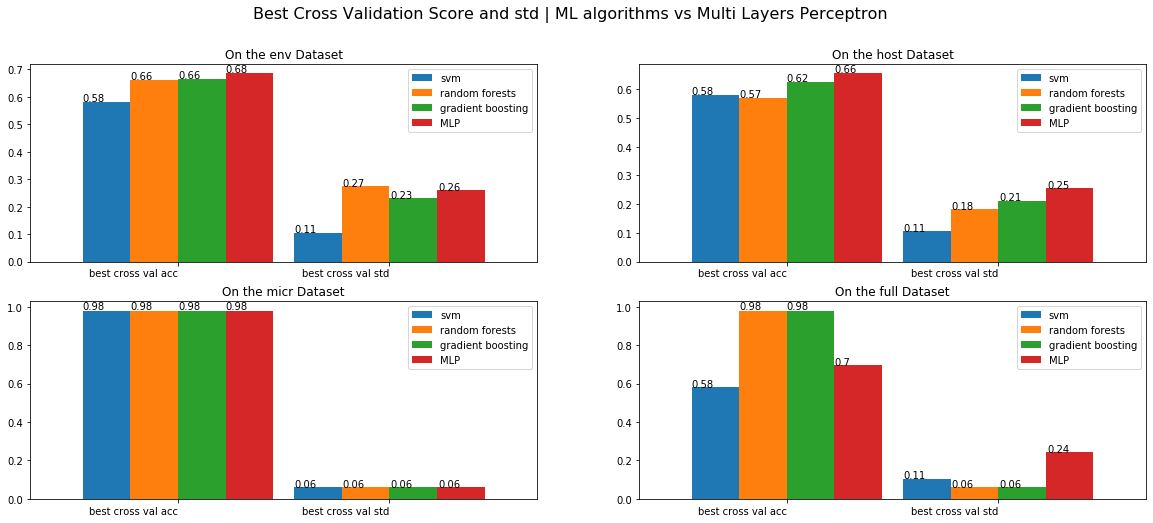

In [47]:
plt.figure(figsize=(20, 8))
plt.suptitle("Best Cross Validation Score and std | ML algorithms vs Multi Layers Perceptron", fontsize=16)
for i,config in enumerate(results):
    # plot the true repartition
    ax = plt.subplot(2, 2, i+1)
    res_ml_df = pd.DataFrame(results[config])
    res_ml_df.plot(ax=ax, kind="bar", width=0.9)
    ax.set_title("On the "+config+" Dataset")
    # layout for the x labes
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
                 rotation_mode="anchor")
    # also show the value on top of barplots
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 2)), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.savefig("./figs/comparison_mlp_ml_microbes.png")

> With the environmental features:
> * MLP achieves the best cross-validation score (0.68) followed by the other algorithms.



> With host features:
> * MLP achieves the best cross-validation score (0.6-) followed by the other algorithms.



> With micr features:
> * With these features all the algorithms achieve and outstanding cross val score of 0.98, these results confirm that these features are the most discriminative with respect to our classification task.



> With all features:
> * Two behaviours are observed: 
    * Random forests and Gradient boosting achieve the same accuracy in this case and when they were fed only with the micr features, this suggests that these two algorithms were able to select to optimal features with respect to the classification task.
    * SVM and the MLP on the other hand yield degraded performances : 0.58 and 0.7 respectively. Which suggests that they were not able to detect the optimal features with respect to the classification task. We attribute this behaviour to the small size of the dataset.

> Overall, we can say that, similarily with the breast cancer dataset and the dataset with golub and al. 1999 a deep learning approach is not suitable (doesn't improve the results of traditional ML algorithms) in this setting (very small high dimensional datasets).